# **INITIALIZATION**

In [75]:
!pip install yfinance
!pip install scikit-learn


     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     -------------------------------------- 60.4/60.4 kB 643.1 kB/s eta 0:00:00
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl.metadata (10.0 kB)
   ---------------------------------------- 0.0/9.1 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.1 MB 20.5 MB/s eta 0:00:01
   -------- ------------------------------- 2.0/9.1 MB 21.6 MB/s eta 0:00:01
   ------------ --------------------------- 2.8/9.1 MB 19.7 MB/s eta 0:00:01
   ---------------- ----------------------- 3.7/9.1 MB 21.4 MB/s eta 0:00:01
   -------------------- ------------------- 4.8/9.1 MB 21.8 MB/s eta 0:00:01
   ------------------------- -------------- 5.8/9.1 MB 21.6 MB/s eta 0:00:01
   ------------------------------ --------- 7.0/9.1 MB 21.3 MB/s eta 0:00:01
   ------------------------------

In [39]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import plotly.graph_objects as go
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '${:,.2f}'.format

# **DATA COLLECTION**

In [40]:
today=datetime.today().strftime('%Y-%m-%d')
start_date = '1950-01-01' #Collects all the data from the start of listing of BTC
data = yf.download('BTC-USD', start_date, today)

[*********************100%%**********************]  1 of 1 completed


In [41]:
data

Open       High        Low      Close  Adj Close       Volume
Date                                                                          
2014-09-17    $465.86    $468.17    $452.42    $457.33    $457.33     21056800
2014-09-18    $456.86    $456.86    $413.10    $424.44    $424.44     34483200
2014-09-19    $424.10    $427.83    $384.53    $394.80    $394.80     37919700
2014-09-20    $394.67    $423.30    $389.88    $408.90    $408.90     36863600
2014-09-21    $408.08    $412.43    $393.18    $398.82    $398.82     26580100
...               ...        ...        ...        ...        ...          ...
2023-11-16 $37,879.98 $37,934.62 $35,545.47 $36,154.77 $36,154.77  26007385366
2023-11-17 $36,164.82 $36,704.48 $35,901.23 $36,596.68 $36,596.68  22445028430
2023-11-18 $36,625.37 $36,839.28 $36,233.31 $36,585.70 $36,585.70  11886022717
2023-11-19 $36,585.77 $37,509.36 $36,414.60 $37,386.55 $37,386.55  12915986553
2023-11-20 $37,374.07 $37,756.82 $36,882.53 $37,476.96 $37,476.96  20888209068

[3352 rows x 6 columns]

# **DATA PRE-PROCESSING**

In [55]:
data.reset_index(inplace=True)
data.columns

Index(['index', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [56]:
data.isnull().any()
data.isnull().sum()

index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [57]:
data

index       Date       Open       High        Low      Close  Adj Close  \
0         0 2014-09-17    $465.86    $468.17    $452.42    $457.33    $457.33   
1         1 2014-09-18    $456.86    $456.86    $413.10    $424.44    $424.44   
2         2 2014-09-19    $424.10    $427.83    $384.53    $394.80    $394.80   
3         3 2014-09-20    $394.67    $423.30    $389.88    $408.90    $408.90   
4         4 2014-09-21    $408.08    $412.43    $393.18    $398.82    $398.82   
...     ...        ...        ...        ...        ...        ...        ...   
3347   3347 2023-11-16 $37,879.98 $37,934.62 $35,545.47 $36,154.77 $36,154.77   
3348   3348 2023-11-17 $36,164.82 $36,704.48 $35,901.23 $36,596.68 $36,596.68   
3349   3349 2023-11-18 $36,625.37 $36,839.28 $36,233.31 $36,585.70 $36,585.70   
3350   3350 2023-11-19 $36,585.77 $37,509.36 $36,414.60 $37,386.55 $37,386.55   
3351   3351 2023-11-20 $37,374.07 $37,756.82 $36,882.53 $37,476.96 $37,476.96   

           Volume  
0        21056800  
1        34483200  
2        37919700  
3        36863600  
4        26580100  
...           ...  
3347  26007385366  
3348  22445028430  
3349  11886022717  
3350  12915986553  
3351  20888209068  

[3352 rows x 8 columns]

In [59]:
data_for_prophet=data[['Date','Open']]
data_for_prophet

Date       Open
0    2014-09-17    $465.86
1    2014-09-18    $456.86
2    2014-09-19    $424.10
3    2014-09-20    $394.67
4    2014-09-21    $408.08
...         ...        ...
3347 2023-11-16 $37,879.98
3348 2023-11-17 $36,164.82
3349 2023-11-18 $36,625.37
3350 2023-11-19 $36,585.77
3351 2023-11-20 $37,374.07

[3352 rows x 2 columns]

In [60]:
new_column_names={
    "Date":"ds",
    "Open":"y",
}
data_for_prophet.rename(columns=new_column_names,inplace=True)
data_for_prophet

ds          y
0    2014-09-17    $465.86
1    2014-09-18    $456.86
2    2014-09-19    $424.10
3    2014-09-20    $394.67
4    2014-09-21    $408.08
...         ...        ...
3347 2023-11-16 $37,879.98
3348 2023-11-17 $36,164.82
3349 2023-11-18 $36,625.37
3350 2023-11-19 $36,585.77
3351 2023-11-20 $37,374.07

[3352 rows x 2 columns]

# **DATA VISUALIZATION**

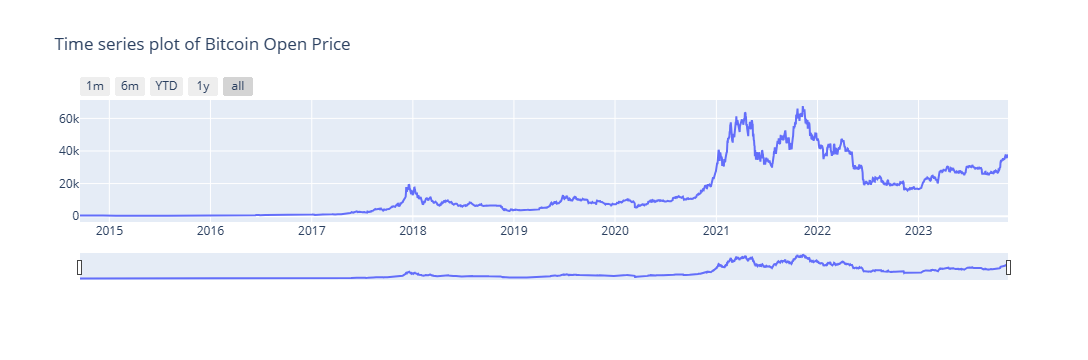

In [61]:
import plotly.graph_objects as go

x = data_for_prophet["ds"]
y = data_for_prophet["y"]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y))

# Set title
fig.update_layout(
    title_text="Time series plot of Bitcoin Open Price"
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            ),
            visible=True
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Show the plot
fig.show()


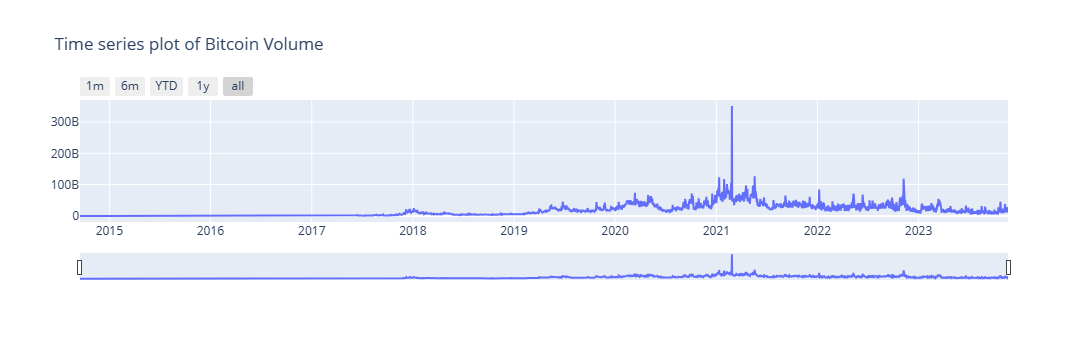

In [62]:
import plotly.graph_objects as go

x = data["Date"]
y = data["Volume"]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y))

# Set title
fig.update_layout(
    title_text="Time series plot of Bitcoin Volume"
)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            ),
            visible=True
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

# Show the plot
fig.show()


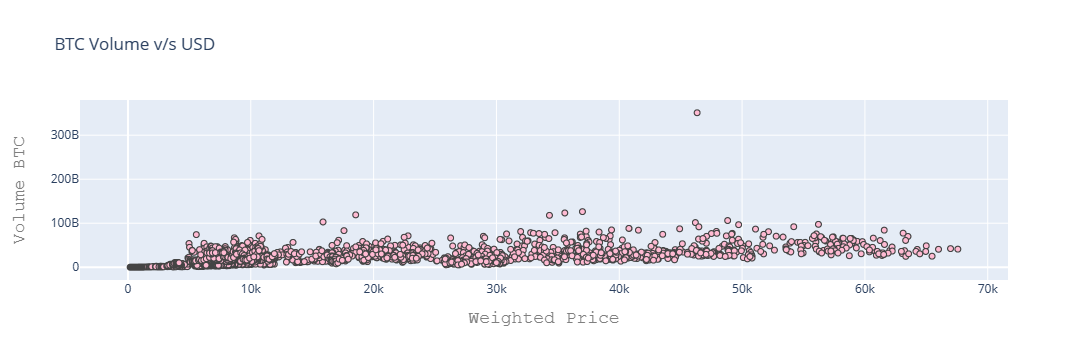

In [63]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)


#BTC Volume vs USD visualization
trace = go.Scattergl(
    x = data['Close'].astype(float),
    y = data['Volume'].astype(float),
    mode = 'markers',
    marker = dict(
        color = '#FFBAD2',
        line = dict(width = 1)
    )
)
layout = go.Layout(
    title='BTC Volume v/s USD',
    xaxis=dict(
        title='Weighted Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Volume BTC',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )))
data = [trace]
fig = go.Figure(data=data, layout=layout)
pyo.iplot(fig, filename='compare_webgl')

# **MODEL TRAINING**

In [64]:
#Create a Prophet model object to train it
model = Prophet(
    seasonality_mode="multiplicative",
)

model.fit(data_for_prophet)

21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:07 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
import pickle
pickle.dump(model,open('Forecaster.pkl','wb'))

# **FORECASTING**

In [66]:
future=model.make_future_dataframe(periods=365)
future

ds
0    2014-09-17
1    2014-09-18
2    2014-09-19
3    2014-09-20
4    2014-09-21
...         ...
3712 2024-11-15
3713 2024-11-16
3714 2024-11-17
3715 2024-11-18
3716 2024-11-19

[3717 rows x 1 columns]

In [67]:
forecast=model.predict(future)
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2014-09-17     $61.64  $-5,687.78   $5,830.86       $61.64       $61.64   
1    2014-09-18     $62.34  $-5,316.41   $5,568.55       $62.34       $62.34   
2    2014-09-19     $63.04  $-5,657.41   $5,629.58       $63.04       $63.04   
3    2014-09-20     $63.74  $-5,212.90   $5,957.94       $63.74       $63.74   
4    2014-09-21     $64.45  $-5,367.89   $5,316.26       $64.45       $64.45   
...         ...        ...         ...         ...          ...          ...   
3712 2024-11-15 $14,482.46  $-1,452.28  $34,357.97     $-765.58   $29,162.68   
3713 2024-11-16 $14,462.73    $-895.93  $34,974.65     $-841.59   $29,240.96   
3714 2024-11-17 $14,443.00  $-1,278.04  $34,302.92     $-917.61   $29,319.25   
3715 2024-11-18 $14,423.27  $-1,937.35  $35,406.88     $-993.62   $29,397.54   
3716 2024-11-19 $14,403.54  $-1,117.38  $34,820.11   $-1,069.64   $29,475.82   

      multiplicative_terms  multiplicative_terms_lower  \
0                   $-0.15                      $-0.15   
1                   $-0.15                      $-0.15   
2                   $-0.16                      $-0.16   
3                   $-0.16                      $-0.16   
4                   $-0.16                      $-0.16   
...                    ...                         ...   
3712                 $0.14                       $0.14   
3713                 $0.14                       $0.14   
3714                 $0.13                       $0.13   
3715                 $0.13                       $0.13   
3716                 $0.12                       $0.12   

      multiplicative_terms_upper  weekly  weekly_lower  weekly_upper  yearly  \
0                         $-0.15  $-0.00        $-0.00        $-0.00  $-0.15   
1                         $-0.15   $0.00         $0.00         $0.00  $-0.15   
2                         $-0.16  $-0.00        $-0.00        $-0.00  $-0.15   
3                         $-0.16  $-0.00        $-0.00        $-0.00  $-0.16   
4                         $-0.16   $0.00         $0.00         $0.00  $-0.16   
...                          ...     ...           ...           ...     ...   
3712                       $0.14  $-0.00        $-0.00        $-0.00   $0.14   
3713                       $0.14  $-0.00        $-0.00        $-0.00   $0.14   
3714                       $0.13   $0.00         $0.00         $0.00   $0.13   
3715                       $0.13   $0.00         $0.00         $0.00   $0.12   
3716                       $0.12  $-0.00        $-0.00        $-0.00   $0.12   

      yearly_lower  yearly_upper  additive_terms  additive_terms_lower  \
0           $-0.15        $-0.15           $0.00                 $0.00   
1           $-0.15        $-0.15           $0.00                 $0.00   
2           $-0.15        $-0.15           $0.00                 $0.00   
3           $-0.16        $-0.16           $0.00                 $0.00   
4           $-0.16        $-0.16           $0.00                 $0.00   
...            ...           ...             ...                   ...   
3712         $0.14         $0.14           $0.00                 $0.00   
3713         $0.14         $0.14           $0.00                 $0.00   
3714         $0.13         $0.13           $0.00                 $0.00   
3715         $0.12         $0.12           $0.00                 $0.00   
3716         $0.12         $0.12           $0.00                 $0.00   

      additive_terms_upper       yhat  
0                    $0.00     $52.39  
1                    $0.00     $52.99  
2                    $0.00     $53.23  
3                    $0.00     $53.78  
4                    $0.00     $54.33  
...                    ...        ...  
3712                 $0.00 $16,506.83  
3713                 $0.00 $16,421.75  
3714                 $0.00 $16,326.87  
3715                 $0.00 $16,236.30  
3716                 $0.00 $16,102.56  

[3717 rows x 19 columns]

In [68]:
forecast[['ds','yhat','yhat_lower','yhat_upper']]

ds       yhat  yhat_lower  yhat_upper
0    2014-09-17     $52.39  $-5,687.78   $5,830.86
1    2014-09-18     $52.99  $-5,316.41   $5,568.55
2    2014-09-19     $53.23  $-5,657.41   $5,629.58
3    2014-09-20     $53.78  $-5,212.90   $5,957.94
4    2014-09-21     $54.33  $-5,367.89   $5,316.26
...         ...        ...         ...         ...
3712 2024-11-15 $16,506.83  $-1,452.28  $34,357.97
3713 2024-11-16 $16,421.75    $-895.93  $34,974.65
3714 2024-11-17 $16,326.87  $-1,278.04  $34,302.92
3715 2024-11-18 $16,236.30  $-1,937.35  $35,406.88
3716 2024-11-19 $16,102.56  $-1,117.38  $34,820.11

[3717 rows x 4 columns]

In [69]:
next_day=(datetime.today()+timedelta(days=1)).strftime('%Y-%m-%d')
forecast[forecast['ds']==next_day]['yhat'].item()

23773.90382949392

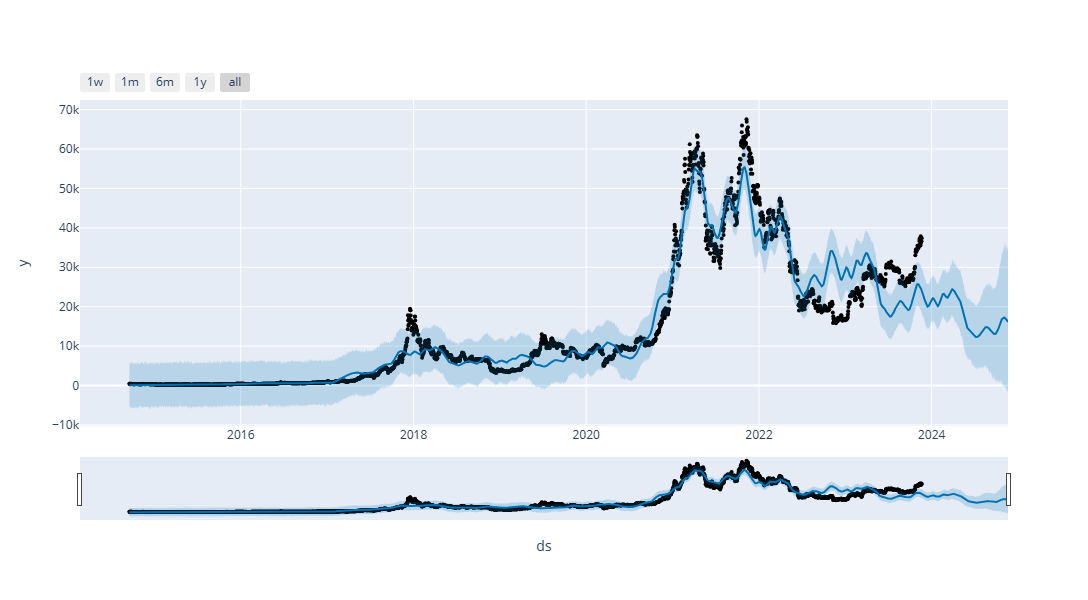

In [71]:
plot_plotly(model,forecast)

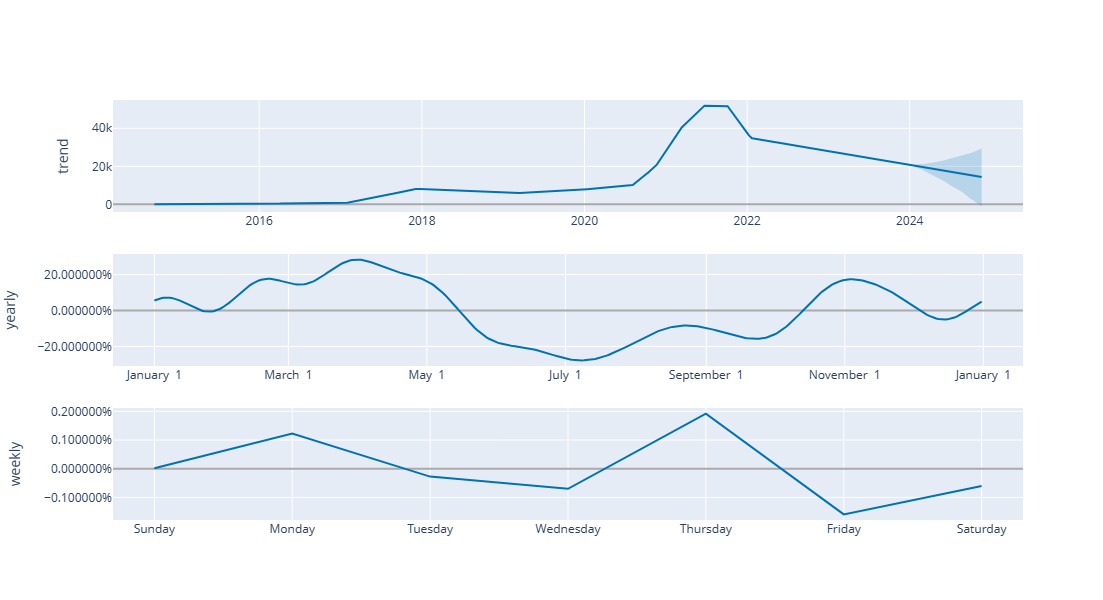

In [72]:
plot_components_plotly(model,forecast)

# **VALIDATION**

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|                                                                                           | 0/15 [00:00<?, ?it/s]21:16:12 - cmdstanpy - INFO - Chain [1] start processing
21:16:12 - cmdstanpy - INFO - Chain [1] done processing
  7%|█████▌                                                                             | 1/15 [00:00<00:04,  2.95it/s]21:16:13 - cmdstanpy - INFO - Chain [1] start processing
21:16:13 - cmdstanpy - INFO - Chain [1] done processing
 13%|███████████                                                                        | 2/15 [00:00<00:04,  2.71it/s]21:16:13 - cmdstanpy - INFO - Chain [1] start processing
21:16:13 - cmdstanpy - INFO - Chain [1] done processing
 20%|████████████████▌                                                                  | 3/15 [00:01<00:04,  2.53it/s]21:16:13 - cmdstanpy - INFO - Chain [1] start processing
21:16:14 - cmdstanpy - I

  horizon            mse      rmse       mae  mape  mdape  smape  coverage
0 37 days $68,810,497.34 $8,295.21 $4,438.49 $0.28  $0.20  $0.25     $0.16
1 38 days $72,837,450.01 $8,534.49 $4,548.13 $0.29  $0.21  $0.25     $0.16
2 39 days $77,291,752.50 $8,791.57 $4,664.25 $0.29  $0.21  $0.26     $0.16
3 40 days $82,080,280.71 $9,059.82 $4,782.83 $0.29  $0.21  $0.26     $0.16
4 41 days $86,899,438.51 $9,321.99 $4,898.16 $0.30  $0.22  $0.27     $0.16


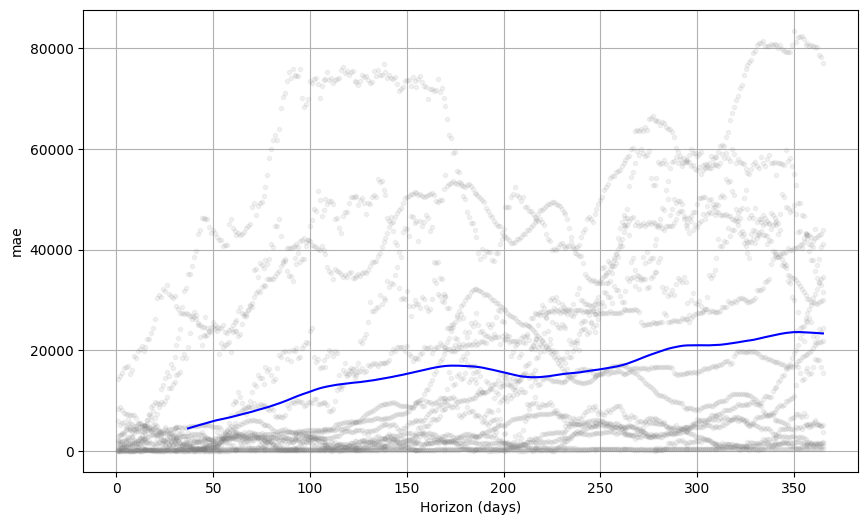

In [73]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

# Perform Cross-Validation
df_cv = cross_validation(model, initial='365 days', period='180 days', horizon='365 days')

# Compute performance metrics
df_p = performance_metrics(df_cv)
print(df_p.head())

# Visualize performance metrics
fig = plot_cross_validation_metric(df_cv, metric='mae')


# **PERFORMANCE METRICS**

In [77]:
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Prepare the data for calculating and visualizing performance metrices
y_true = data_for_prophet['y']
forecast_based_on_data = forecast[forecast['ds'] <= datetime(2023, 11, 20)]

# Extract yhat column from the filtered DataFrame
y_pred = forecast_based_on_data['yhat']

# Mean Squared Error (MSE)
mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# R-squared (R2)
r2 = r2_score(y_true=y_true, y_pred=y_pred)
print(f"R-squared (R2): {r2}")

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Squared Error (MSE): 19178199.67176853
Mean Absolute Error (MAE): 2796.582551703893
R-squared (R2): 0.9251720737281792
Root Mean Squared Error (RMSE): 4379.292142774735
